#  Here we compute $\sigma(f_{NL})$ using the estimated derivatives computed with CAMB


In [1]:
import numpy as np
import scipy as sp
#import pyccl as ccl
import math
import matplotlib.pyplot as plt
from scipy import integrate
from functools import partial
from scipy.integrate import quad, dblquad
import pyccl as ccl
import camb
from camb import model, initialpower

In [2]:
mnu_fid=0.06
coeff_nu=0.05

H0_fid=67.7
coeff_h0=0.01

ombh2_fid=0.02247
coeff_ombh=0.01

omch2_fid=0.11923
coeff_omch=0.01

tau_fid=0.0568
coeff_tau=0.5

ns_fid=0.9675
coeff_ns=0.01

As_fid=2.215e-9
coeff_As=0.01


npointp=1000
kminp=5e-4
kmaxp=0.5
hierarchy='normal'

pars = camb.CAMBparams()
pars.set_accuracy(AccuracyBoost=2)
pars.set_cosmology(H0=H0_fid, ombh2=ombh2_fid, omch2=omch2_fid,mnu=mnu_fid,tau=tau_fid,neutrino_hierarchy=hierarchy)
pars.InitPower.set_params(ns=ns_fid,As=As_fid)
zeffp=3
pars.set_matter_power(redshifts=[zeffp], kmax=10)
results= camb.get_results(pars)
k_fid,z_fid,p_fid=results.get_matter_power_spectrum(minkh=kminp,maxkh=kmaxp,npoints=npointp)

def power_camb(zeff):
    pars = camb.CAMBparams()
    pars.set_accuracy(AccuracyBoost=2)
    pars.set_cosmology(H0=H0_fid, ombh2=ombh2_fid, omch2=omch2_fid,mnu=mnu_fid,tau=tau_fid,neutrino_hierarchy=hierarchy)
    pars.InitPower.set_params(ns=ns_fid,As=As_fid)
    pars.set_matter_power(redshifts=[zeff], kmax=10)
    results= camb.get_results(pars)
    k_fid,z_fid,p_fid=results.get_matter_power_spectrum(minkh=kminp,maxkh=kmaxp,npoints=npointp,var1=model.Transfer_nonu,var2=model.Transfer_nonu)
    return p_fid[0]



# First we read the derivative of P(k,z) wrt cosmo parameter.

In [18]:
dP_dh=np.transpose(np.loadtxt('derivative_Camb/dP_dh.txt',skiprows=0,unpack=True))
df_dh=np.transpose(np.loadtxt('derivative_Camb/df_dh.txt',skiprows=0,unpack=True))
    
dP_dAs=np.transpose(np.loadtxt('derivative_Camb/dP_dAs.txt',skiprows=0,unpack=True))
df_dAs=np.transpose(np.loadtxt('derivative_Camb/df_dAs.txt',skiprows=0,unpack=True))

dP_dns=np.transpose(np.loadtxt('derivative_Camb/dP_dns.txt',skiprows=0,unpack=True))
df_dns=np.transpose(np.loadtxt('derivative_Camb/df_dns.txt',skiprows=0,unpack=True))

dP_dtau=np.transpose(np.loadtxt('derivative_Camb/dP_dtau.txt',skiprows=0,unpack=True))
df_dtau=np.transpose(np.loadtxt('derivative_Camb/df_dtau.txt',skiprows=0,unpack=True))

dP_domch=np.transpose(np.loadtxt('derivative_Camb/dP_domch.txt',skiprows=0,unpack=True))
df_domch=np.transpose(np.loadtxt('derivative_Camb/df_domch.txt',skiprows=0,unpack=True))

dP_dombh=np.transpose(np.loadtxt('derivative_Camb/dP_dombh.txt',skiprows=0,unpack=True))
df_dombh=np.transpose(np.loadtxt('derivative_Camb/df_dombh.txt',skiprows=0,unpack=True))

dP_dnu=np.transpose(np.loadtxt('derivative_Camb/dP_dnu.txt',skiprows=0,unpack=True))
df_dnu=np.transpose(np.loadtxt('derivative_Camb/df_dnu.txt',skiprows=0,unpack=True))

Zeff=[0.7,1.1,1.5,2,2.55,2.7,3.1,3.3,4.1]
Pfid=[power_camb(z) for z in Zeff]
Zeff.append(6)

# Code to compute the Fisher matrix ((7+1)x7/2=28 coefficients)

In [21]:
def dichotomie(k):
    a = 0
    b = npointp-1
    while a <= b:
        m = (a + b) // 2
        if k_fid[m] == k:
            # on a trouvé v
            return m
        elif k_fid[m] < k:
            a = m + 1
        else:
            b = m - 1
    # on a a > b
    return a

cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=H0_fid/100, A_s=As_fid, n_s=ns_fid,transfer_function='boltzmann_camb',m_nu=0.06)

Omega_m=cosmo['Omega_m']
Omega_b=cosmo['Omega_b']
Omega_c=cosmo['Omega_c']
Omega_l=1-Omega_m
print(Omega_m)

def Vsurvey(z,dz,sky):    
    Omega     = sky*(math.pi/180)**2 # get rid of unit
    d2        = ccl.comoving_radial_distance(cosmo,1/(1+z))
    d3        = ccl.comoving_radial_distance(cosmo,1/(1+z+dz))
    return Omega/3 * (d3**3 - d2**3)*h**3
   
    
    
    
deltac=1.686
H0=68.14
h=H0/100
c=2.99*10**5
#Set up integration options
nlim=1000


def D(z):
    return ccl.growth_factor(cosmo,1/(1+z))

def f(z):
    return ccl.growth_rate(cosmo,1/(1+z))


def Pm(k,z1):
    return ccl.linear_matter_power(cosmo, k*h, 1/(1+z1))*h**3

def Pz0(k):
     return ccl.linear_matter_power(cosmo, k*h, 1/(1+0))*h**3
 
def sigma_8(z1):
     return (Pm(0.01,z1)/Pz0(0.01))**0.5*ccl.sigma8(cosmo)
def bias(z1,gal):
    if gal=='LRG':
        return 1.7*D(0)/D(z1)#LRG
    if gal=='ELG':
        return D(0)/D(z1)#ELG
    if gal=='ELG_DESI':
        return 0.84*D(0)/D(z1)#ELG
    if gal=='LBG24':
        return (-0.98*(24-25)+0.11)*(1+z1)+(0.12*(24-25)+0.17)*(1+z1)**2#LBG
    if gal=='LBG24.2':
        return (-0.98*(24.2-25)+0.11)*(1+z1)+(0.12*(24.2-25)+0.17)*(1+z1)**2#LBG
    if gal=='LBG24.5':
        return (-0.98*(24.5-25)+0.11)*(1+z1)+(0.12*(24.5-25)+0.17)*(1+z1)**2#LBG
    if gal=='LBG25':
        return 0.11*(1+z1)+0.17*(1+z1)**2#LBG
    if gal=='LBG25.5':
        return (-0.98*(25.5-25)+0.11)*(1+z1)+(0.12*(25.5-25)+0.17)*(1+z1)**2#LBG
    if gal=='QSO':
        return 0.53+0.29*(1+z1)**2
    print('galaxy type unknown')   

def Dl(z):
    return ccl.background.luminosity_distance(cosmo, 1/(1+z))



def Mc(z,mmax):
    #return 24.5-5*np.log10(Dl(z)*10**6/10)+2.5*np.log10(1+z)#Megamapper
    return mmax-5*np.log10(Dl(z)*10**6/10)+2.5*np.log10(1+z)#Megamapper

def phi_m(M,z):
    if z<2.5:
        Muv=-20.6
        phi_star=9.7/1000
        alpha=-1.6
        #print(1)
    elif z<3.5:
        Muv=-20.86#star
        phi_star=5.04/1000
        alpha=-1.78
        #print(2)
    elif z<4.5:
        Muv=-20.63#star
        phi_star=9.25/1000
        alpha=-1.57
        #print(3)
    elif z<5.5:
        Muv=-20.96
        phi_star=3.22/1000
        alpha=-1.6
        #print(4)
    else:
        Muv=-20.91#star
        phi_star=1.64/1000
        alpha=-1.87
        #print(5)
    
    return math.log(10)/2.5*phi_star*10**(-0.4*(1+alpha)*(M-Muv))*math.exp(-10**(-0.4*(M-Muv)))

def n_LBG(z,mmax):
    mc=Mc(z,mmax)
    return quad(lambda M:phi_m(M,z),-25,mc ,epsrel=0.0000001,epsabs=0.00000001,limit=nlim)[0]


#%%


def F_Neutrino(z2,zeff,dz,n,sky,gal,kmax):
    izeff=0
    while abs(zeff-Zeff[izeff])>abs(zeff-Zeff[izeff+1]):
        izeff=izeff+1
    z=Zeff[izeff]
    
    f_z=f(z)
    bg=bias(z,gal)

    V=Vsurvey(z2,dz,sky)
    #print(V)
    
    nlim=1000
    kmin=2*math.pi/V**(1/3)
    #kmax=0.1#*D(0)/D(z2+dz)#/h
    #print('main ', (bg*sigma8+f_z*sigma8*1**2)**2)
 
    def dP1(i):#neutrino
        return dP_dnu[izeff][i]#*10**(-1)
    def dP2(i):#h0
        return dP_dh[izeff][i]#*10**(-1)
    def dP3(i):#omega_b
        return dP_dombh[izeff][i]#*10**(-4)
    def dP4(i):#omega_c
        return dP_domch[izeff][i]#*10**(-3)
    def dP5(i):#ns
        return dP_dns[izeff][i]#*10**(-2)
    def dP6(i):#As
        return dP_dAs[izeff][i]*As_fid#*10**(-10)
    def dP7(i):#tau
        return dP_dtau[izeff][i]#*10**(-3)
    
    
    def df1():#neutrino
        return df_dnu[izeff]#*10**(-1)
    def df2():#h0
        return df_dh[izeff]#*10**(-1)
    def df3():#omega_b
        return df_dombh[izeff]#*10**(-4)
    def df4():#omega_c
        return df_domch[izeff]#*10**(-3)
    def df5():#ns
        return df_dns[izeff]#*10**(-2)
    def df6():#As
        return df_dAs[izeff]*As_fid#*10**(-10)
    def df7():#tau
        return df_dtau[izeff]#*10**(-3)
    
    
    def integ_mu1(j):  #nd j to k in kfid 
        pk=Pfid[izeff][j]
        def integrand(mu):
            return (n*pk*(bg+f_z*mu**2)**2/(n*pk*(bg+f_z*mu**2)**2+1))**2
        return 2*quad(integrand,0,1)[0]
    
    def integ_mu2(j):  #nd j to k in kfid 
        pk=Pfid[izeff][j]
        def integrand(mu):
            return (n*pk*(bg+f_z*mu**2)**2/(n*pk*(bg+f_z*mu**2)**2+1))**2*2*mu**2/(bg+f_z*mu**2)
        return 2*quad(integrand,0,1)[0]
    
    def integ_mu3(j):  #nd j to k in kfid 
        pk=Pfid[izeff][j]
        def integrand(mu):
            return (n*pk*(bg+f_z*mu**2)**2/(n*pk*(bg+f_z*mu**2)**2+1))**2*4*mu**4/(bg+f_z*mu**2)**2
        return 2*quad(integrand,0,1)[0]
    
    Integ_mu1=[integ_mu1(j) for j in range(npointp)]
    Integ_mu2=[integ_mu2(j) for j in range(npointp)]
    Integ_mu3=[integ_mu3(j) for j in range(npointp)]
    
    #return Integ_mu
    def integrat_neut(int_n):
       
        #print('power ',n*pk)
        def D2logP(ik,int_n):
            if int_n==11:
                return dP1(ik)**2/Pfid[izeff][ik]**2
            if int_n==12:
                return dP1(ik)*dP2(ik)/Pfid[izeff][ik]**2
            if int_n==13:
                return dP1(ik)*dP3(ik)/Pfid[izeff][ik]**2
            if int_n==14:
                return dP1(ik)*dP4(ik)/Pfid[izeff][ik]**2
            if int_n==15:
                return dP1(ik)*dP5(ik)/Pfid[izeff][ik]**2
            if int_n==16:
                return dP1(ik)*dP6(ik)/Pfid[izeff][ik]**2
            if int_n==17:
                return dP1(ik)*dP7(ik)/Pfid[izeff][ik]**2
            
            if int_n==22:
                return dP2(ik)*dP2(ik)/Pfid[izeff][ik]**2
            if int_n==23:
                return dP2(ik)*dP3(ik)/Pfid[izeff][ik]**2
            if int_n==24:
                return dP2(ik)*dP4(ik)/Pfid[izeff][ik]**2
            if int_n==25:
                return dP2(ik)*dP5(ik)/Pfid[izeff][ik]**2
            if int_n==26:
                return dP2(ik)*dP6(ik)/Pfid[izeff][ik]**2
            if int_n==27:
                return dP2(ik)*dP7(ik)/Pfid[izeff][ik]**2
            
            if int_n==33:
                return dP3(ik)*dP3(ik)/Pfid[izeff][ik]**2
            if int_n==34:
                return dP3(ik)*dP4(ik)/Pfid[izeff][ik]**2
            if int_n==35:
                return dP3(ik)*dP5(ik)/Pfid[izeff][ik]**2
            if int_n==36:
                return dP3(ik)*dP6(ik)/Pfid[izeff][ik]**2
            if int_n==37:
                return dP3(ik)*dP7(ik)/Pfid[izeff][ik]**2
            
            if int_n==44:
                return dP4(ik)*dP4(ik)/Pfid[izeff][ik]**2
            if int_n==45:
                return dP4(ik)*dP5(ik)/Pfid[izeff][ik]**2
            if int_n==46:
                return dP4(ik)*dP6(ik)/Pfid[izeff][ik]**2
            if int_n==47:
                return dP4(ik)*dP7(ik)/Pfid[izeff][ik]**2
            
            if int_n==55:
                return dP5(ik)*dP5(ik)/Pfid[izeff][ik]**2
            if int_n==56:
                return dP5(ik)*dP6(ik)/Pfid[izeff][ik]**2
            if int_n==57:
                return dP5(ik)*dP7(ik)/Pfid[izeff][ik]**2
            
            if int_n==66:
                return dP6(ik)*dP6(ik)/Pfid[izeff][ik]**2
            if int_n==67:
                return dP6(ik)*dP7(ik)/Pfid[izeff][ik]**2
            
            if int_n==77:
                return dP7(ik)*dP7(ik)/Pfid[izeff][ik]**2
            
        def DlogPDf(ik,int_n):
            if int_n==11:
                return dP1(ik)/Pfid[izeff][ik]*df1()*2
            if int_n==12:
                return dP1(ik)/Pfid[izeff][ik]*df2()+dP2(ik)/Pfid[izeff][ik]*df1()
            if int_n==13:
                return dP1(ik)/Pfid[izeff][ik]*df3()+dP3(ik)/Pfid[izeff][ik]*df1()
            if int_n==14:
                return dP1(ik)/Pfid[izeff][ik]*df4()+dP4(ik)/Pfid[izeff][ik]*df1()
            if int_n==15:
                return dP1(ik)/Pfid[izeff][ik]*df5()+dP5(ik)/Pfid[izeff][ik]*df1()
            if int_n==16:
                return dP1(ik)/Pfid[izeff][ik]*df6()+dP6(ik)/Pfid[izeff][ik]*df1()
            if int_n==17:
                return dP1(ik)/Pfid[izeff][ik]*df7()+dP7(ik)/Pfid[izeff][ik]*df1()
            
            if int_n==22:
                return dP2(ik)/Pfid[izeff][ik]*df2()+dP2(ik)/Pfid[izeff][ik]*df2()
            if int_n==23:
                return dP2(ik)/Pfid[izeff][ik]*df3()+dP3(ik)/Pfid[izeff][ik]*df2()
            if int_n==24:
                return dP2(ik)/Pfid[izeff][ik]*df4()+dP4(ik)/Pfid[izeff][ik]*df2()
            if int_n==25:
                return dP2(ik)/Pfid[izeff][ik]*df5()+dP5(ik)/Pfid[izeff][ik]*df2()
            if int_n==26:
                return dP2(ik)/Pfid[izeff][ik]*df6()+dP6(ik)/Pfid[izeff][ik]*df2()
            if int_n==27:
                return dP2(ik)/Pfid[izeff][ik]*df7()+dP7(ik)/Pfid[izeff][ik]*df2()
            
            if int_n==33:
                return dP3(ik)/Pfid[izeff][ik]*df3()+dP3(ik)/Pfid[izeff][ik]*df3()
            if int_n==34:
                return dP3(ik)/Pfid[izeff][ik]*df4()+dP4(ik)/Pfid[izeff][ik]*df3()
            if int_n==35:
                return dP3(ik)/Pfid[izeff][ik]*df5()+dP5(ik)/Pfid[izeff][ik]*df3()
            if int_n==36:
                return dP3(ik)/Pfid[izeff][ik]*df6()+dP6(ik)/Pfid[izeff][ik]*df3()
            if int_n==37:
                return dP3(ik)/Pfid[izeff][ik]*df7()+dP7(ik)/Pfid[izeff][ik]*df3()
            
            if int_n==44:
                return dP4(ik)/Pfid[izeff][ik]*df4()+dP4(ik)/Pfid[izeff][ik]*df4()
            if int_n==45:
                return dP4(ik)/Pfid[izeff][ik]*df5()+dP5(ik)/Pfid[izeff][ik]*df4()
            if int_n==46:
                return dP4(ik)/Pfid[izeff][ik]*df6()+dP6(ik)/Pfid[izeff][ik]*df4()
            if int_n==47:
                return dP4(ik)/Pfid[izeff][ik]*df7()+dP7(ik)/Pfid[izeff][ik]*df4()
            
            if int_n==55:
                return dP5(ik)/Pfid[izeff][ik]*df5()+dP5(ik)/Pfid[izeff][ik]*df5()
            if int_n==56:
                return dP5(ik)/Pfid[izeff][ik]*df6()+dP6(ik)/Pfid[izeff][ik]*df5()
            if int_n==57:
                return dP5(ik)/Pfid[izeff][ik]*df7()+dP7(ik)/Pfid[izeff][ik]*df5()
            
            if int_n==66:
                return dP6(ik)/Pfid[izeff][ik]*df6()+dP6(ik)/Pfid[izeff][ik]*df6()
            if int_n==67:
                return dP6(ik)/Pfid[izeff][ik]*df7()+dP7(ik)/Pfid[izeff][ik]*df6()
            
            if int_n==77:
                return dP7(ik)/Pfid[izeff][ik]*df7()+dP7(ik)/Pfid[izeff][ik]*df7()
            
        def D2f(int_n):
            if int_n==11:
                return df1()*df1()
            if int_n==12:
                return df1()*df2()
            if int_n==13:
                return df1()*df3()
            if int_n==14:
                return df1()*df4()
            if int_n==15:
                return df1()*df5()
            if int_n==16:
                return df1()*df6()
            if int_n==17:
                return df1()*df7()
            
            if int_n==22:
                return df2()*df2()
            if int_n==23:
                return df2()*df3()
            if int_n==24:
                return df2()*df4()
            if int_n==25:
                return df2()*df5()
            if int_n==26:
                return df2()*df6()
            if int_n==27:
                return df2()*df7()
            
            if int_n==33:
                return df3()*df3()
            if int_n==34:
                return df3()*df4()
            if int_n==35:
                return df3()*df5()
            if int_n==36:
                return df3()*df6()
            if int_n==37:
                return df3()*df7()
            
            if int_n==44:
                return df4()*df4()
            if int_n==45:
                return df4()*df5()
            if int_n==46:
                return df4()*df6()
            if int_n==47:
                return df4()*df7()
            
            if int_n==55:
                return df5()*df5()
            if int_n==56:
                return df5()*df6()
            if int_n==57:
                return df5()*df7()
            
            if int_n==66:
                return df6()*df6()
            if int_n==67:
                return df6()*df7()
            
            if int_n==77:
                return df7()*df7()
            
        ikmin=dichotomie(kmin)
        ikmax=dichotomie(kmax)
        #print(ikmin,ikmax)
        
        Sum=0
        for ik in range(ikmin,ikmax):
            k=k_fid[ik]
            noise_mu1=Integ_mu1[ik]
            noise_mu2=Integ_mu2[ik]
            noise_mu3=Integ_mu3[ik]
            Sum=Sum+(k_fid[ik+1]-k_fid[ik])*1/2*k**2*(noise_mu1*D2logP(ik,int_n)+noise_mu2*DlogPDf(ik,int_n)+noise_mu3*D2f(int_n))
        return Sum
        
        
    def F_neut():
        #print('ok')
        
        f11=V/(4*math.pi**2)*integrat_neut(11)
        f12=V/(4*math.pi**2)*integrat_neut(12)
        f13=V/(4*math.pi**2)*integrat_neut(13)
        f14=V/(4*math.pi**2)*integrat_neut(14)
        f15=V/(4*math.pi**2)*integrat_neut(15)
        f16=V/(4*math.pi**2)*integrat_neut(16)
        f17=V/(4*math.pi**2)*integrat_neut(17)
        f22=V/(4*math.pi**2)*integrat_neut(22)
        #print('f22=', f22)
        f23=V/(4*math.pi**2)*integrat_neut(23)
        f24=V/(4*math.pi**2)*integrat_neut(24)
        f25=V/(4*math.pi**2)*integrat_neut(25)
        f26=V/(4*math.pi**2)*integrat_neut(26)
        f27=V/(4*math.pi**2)*integrat_neut(27)
        #print('ok', f27)
        f33=V/(4*math.pi**2)*integrat_neut(33)
        #print('f33=', f33)
        f34=V/(4*math.pi**2)*integrat_neut(34)
        f35=V/(4*math.pi**2)*integrat_neut(35)
        f36=V/(4*math.pi**2)*integrat_neut(36)
        f37=V/(4*math.pi**2)*integrat_neut(37)
        f44=V/(4*math.pi**2)*integrat_neut(44)
        #print('f44=', f44)
        f45=V/(4*math.pi**2)*integrat_neut(45)
        #print('ok', f45)
        f46=V/(4*math.pi**2)*integrat_neut(46)
        f47=V/(4*math.pi**2)*integrat_neut(47)
        
        f55=V/(4*math.pi**2)*integrat_neut(55)
        #print('f55=', f55)
        f56=V/(4*math.pi**2)*integrat_neut(56)
        f57=V/(4*math.pi**2)*integrat_neut(57)
        
        f66=V/(4*math.pi**2)*integrat_neut(66)
        #print('f66=', f66)
        f67=V/(4*math.pi**2)*integrat_neut(67)
        f77=V/(4*math.pi**2)*integrat_neut(77)
        #print('f77=', f77)
        return np.array([[f11,f12,f13,f14,f15,f16,f17],[f12,f22,f23,f24,f25,f26,f27],[f13,f23,f33,f34,f35,f36,f37],[f14,f24,f34,f44,f45,f46,f47],[f15,f25,f35,f45,f55,f56,f57],[f16,f26,f36,f46,f56,f66,f67],[f17,f27,f37,f47,f57,f67,f77]])
        
    
    A=F_neut()
    return A

#%%



def Prior_Planck():
    sigma_nu=0.35#0.35
    sigma_h=0.5
    sigma_wb=0.00015
    sigma_wc= 0.00099
    sigma_ns= 0.0039
    sigma_lnAs=0.014 
    sigma_tau=0.0072
    return np.array([[1/sigma_nu**2,0,0,0,0,0,0],[0,1/sigma_h**2,0,0,0,0,0],[0,0,1/sigma_wb**2,0,0,0,0],[0,0,0,1/sigma_wc**2,0,0,0],[0,0,0,0,1/sigma_ns,0,0],[0,0,0,0,0,1/sigma_lnAs**2,0],[0,0,0,0,0,0,1/sigma_tau**2]])    
    #return np.array([[1/sigma_nu**2,0,0,0,0,0],[0,1/sigma_h**2,0,0,0,0],[0,0,1/sigma_wb**2,0,0,0],[0,0,0,1/sigma_wc**2,0,0],[0,0,0,1/sigma_ns,0,0],[0,0,0,0,0,1/sigma_lnAs**2]])    

FPlanck=Prior_Planck()
#%%
def Fisher_DESI():
    f1=F_Neutrino(0.65,0.70,0.3,0.0003,14000,'LRG',0.1)
    f2=F_Neutrino(0.65,0.70,0.3,0.00098,14000,'ELG_DESI',0.1)
    F1=np.add(f1,f2)
    f3=F_Neutrino(1.05,1.1,0.3,0.00045,14000,'ELG_DESI',0.1)
    f4=F_Neutrino(1.35,1.45,0.3,0.00013,14000,'ELG_DESI',0.1)
    F2=np.add(f3,f4)
    F=np.add(F1,F2)
    return F
FDesi=Fisher_DESI()

def Fisher_DESI_QSO():
    f1=F_Neutrino(1.96,2.2,0.47,0.000017,14000,'QSO',0.1)
    f2=F_Neutrino(2.43,2.7,1.05,0.0000063,14000,'QSO',0.1)
    F1=np.add(f1,f2)
    return F1

FDesi_Q=Fisher_DESI_QSO()


def Fisher_DESI3():
    f1=F_Neutrino(0.65,0.70,0.3,0.0003,14000,'LRG',0.3)
    f2=F_Neutrino(0.65,0.70,0.3,0.00098,14000,'ELG_DESI',0.3)
    F1=np.add(f1,f2)
    f3=F_Neutrino(1.05,1.1,0.3,0.00045,14000,'ELG_DESI',0.3)
    f4=F_Neutrino(1.35,1.45,0.3,0.00013,14000,'ELG_DESI',0.3)
    F2=np.add(f3,f4)
    F=np.add(F1,F2)
    return F
FDesi3=Fisher_DESI3()

def Fisher_DESI_QSO3():
    f1=F_Neutrino(1.96,2.2,0.47,0.000017,14000,'QSO',0.3)
    f2=F_Neutrino(2.43,2.7,1.05,0.0000063,14000,'QSO',0.3)
    F1=np.add(f1,f2)
    return F1

FDesi_Q3=Fisher_DESI_QSO3()



0.3164098525406182


/nfs/pic.es/user/w/wdassign/.conda/envs/test-z_clust/lib/python3.9/site-packages/pyccl/core.py:742: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


## MegaMapper

In [30]:
kmax=0.1
print('constrains Megamapper sum redshift, with Planck')
Fm=F_Neutrino(2,2.1,0.5,0.00079,14000,'LBG24.5',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036,14000,'LBG24.5',kmax)+F_Neutrino(3,3.1,1,0.00011,14000,'LBG24.5',kmax)+F_Neutrino(4,4.1,1,0.00007,14000,'LBG24.5',kmax)
print(np.linalg.inv(FPlanck+Fm)[0][0]**0.5)
print('constrains Megamapper with Planck and Desi')
print(np.linalg.inv(FPlanck+Fm+FDesi+FDesi_Q)[0][0]**0.5)
print('')
print('constrains double  Megamapper like sum redshift, with Planck')
Fmm=F_Neutrino(2,2.1,0.5,0.00079,28000,'LBG24.5',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036,28000,'LBG24.5',kmax)+F_Neutrino(3,3.1,1,0.00011,28000,'LBG24.5',kmax)+F_Neutrino(4,4.1,1,0.00007,28000,'LBG24.5',kmax)
print(np.linalg.inv(FPlanck+Fmm)[0][0]**0.5)
print('constrains double Megamapper like, with Planck and Desi')
print(np.linalg.inv(FPlanck+Fmm+FDesi+FDesi_Q)[0][0]**0.5)
print('')

kmax=0.3
print('constrains Megamapper sum redshift, with Planck')
Fm=F_Neutrino(2,2.1,0.5,0.00079,14000,'LBG24.5',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036,14000,'LBG24.5',kmax)+F_Neutrino(3,3.1,1,0.00011,14000,'LBG24.5',kmax)+F_Neutrino(4,4.1,1,0.00007,14000,'LBG24.5',kmax)
print(np.linalg.inv(FPlanck+Fm)[0][0]**0.5)
print('constrains Megamapper with Planck and Desi')
print(np.linalg.inv(FPlanck+Fm+FDesi+FDesi_Q)[0][0]**0.5)
print('')
print('constrains double  Megamapper like sum redshift, with Planck')
Fmm=F_Neutrino(2,2.1,0.5,0.00079,28000,'LBG24.5',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036,28000,'LBG24.5',kmax)+F_Neutrino(3,3.1,1,0.00011,28000,'LBG24.5',kmax)+F_Neutrino(4,4.1,1,0.00007,28000,'LBG24.5',kmax)
print(np.linalg.inv(FPlanck+Fmm)[0][0]**0.5)
print('constrains double Megamapper like, with Planck and Desi')
print(np.linalg.inv(FPlanck+Fmm+FDesi+FDesi_Q)[0][0]**0.5)
print('')


constrains Megamapper sum redshift, with Planck
0.041824639813333495
constrains Megamapper with Planck and Desi
0.03296036404722485

constrains double  Megamapper like sum redshift, with Planck
0.036797229331907134
constrains double Megamapper like, with Planck and Desi
0.03013231680163215

constrains Megamapper sum redshift, with Planck
0.023866364207553142
constrains Megamapper with Planck and Desi
0.02187902477504982

constrains double  Megamapper like sum redshift, with Planck
0.01815521523153613
constrains double Megamapper like, with Planck and Desi
0.017198305852840882



## MSE

In [29]:
kmax=0.1
print('constrains MSE ELG kmax=0.1')
Fmse=F_Neutrino(1.6,2,0.8,0.00018,10000,'ELG',kmax)
print(np.linalg.inv(FPlanck+Fmse)[0][0]**0.5)
print('constrains MSE ELG with Planck and Desi')
print(np.linalg.inv(FPlanck+Fmse+FDesi+FDesi_Q)[0][0]**0.5)
print('constrains MSE LBG')
Fmse=F_Neutrino(2.4,2.55,0.4,0.00023,10000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.4,0.00011,10000,'LBG24.2',kmax)+F_Neutrino(3.2,3.3,0.8,0.000043,10000,'LBG24.2',kmax)
print(np.linalg.inv(FPlanck+Fmse)[0][0]**0.5)
print('constrains MSE LBG with Planck and Desi')
print(np.linalg.inv(FPlanck+Fmse+FDesi+FDesi_Q)[0][0]**0.5)
print('constrains ELG+LBG')
Fmse=F_Neutrino(2.4,2,0.4,0.00023,10000,'ELG',kmax)+F_Neutrino(2.4,2.55,0.4,0.00023,10000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.4,0.00011,10000,'LBG24.2',kmax)+F_Neutrino(3.2,3.3,0.8,0.000043,10000,'LBG24.2',kmax)
print(np.linalg.inv(FPlanck+Fmse)[0][0]**0.5)
print('constrains MSE LBG+ELG with Planck and Desi')
print(np.linalg.inv(FPlanck+Fmse+FDesi+FDesi_Q)[0][0]**0.5)
print('')

kmax=0.3
print('constrains MSE ELG kmax=0.3')
Fmse=F_Neutrino(1.6,2,0.8,0.00018,10000,'ELG',kmax)
print(np.linalg.inv(FPlanck+Fmse)[0][0]**0.5)
print('constrains MSE ELG with Planck and Desi')
print(np.linalg.inv(FPlanck+Fmse+FDesi+FDesi_Q)[0][0]**0.5)
print('constrains MSE LBG')
Fmse=F_Neutrino(2.4,2.55,0.4,0.00023,10000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.4,0.00011,10000,'LBG24.2',kmax)+F_Neutrino(3.2,3.3,0.8,0.000043,10000,'LBG24.2',kmax)
print(np.linalg.inv(FPlanck+Fmse)[0][0]**0.5)
print('constrains MSE LBG with Planck and Desi')
print(np.linalg.inv(FPlanck+Fmse+FDesi+FDesi_Q)[0][0]**0.5)
print('constrains ELG+LBG')
Fmse=F_Neutrino(2.4,2,0.4,0.00023,10000,'ELG',kmax)+F_Neutrino(2.4,2.55,0.4,0.00023,10000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.4,0.00011,10000,'LBG24.2',kmax)+F_Neutrino(3.2,3.3,0.8,0.000043,10000,'LBG24.2',kmax)
print(np.linalg.inv(FPlanck+Fmse)[0][0]**0.5)
print('constrains MSE LBG+ELG with Planck and Desi')
print(np.linalg.inv(FPlanck+Fmse+FDesi+FDesi_Q)[0][0]**0.5)
print('')

constrains MSE ELG kmax=0.1
0.04998403608409684
constrains MSE ELG with Planck and Desi
0.04095620150155023
constrains MSE LBG
0.0506291465469031
constrains MSE LBG with Planck and Desi
0.03738671384960118
constrains ELG+LBG
0.04831508452111293
constrains MSE LBG+ELG with Planck and Desi
0.03730904333812249

constrains MSE ELG kmax=0.3
0.0448265335375801
constrains MSE ELG with Planck and Desi
0.03827476957053382
constrains MSE LBG
0.04337857132730824
constrains MSE LBG with Planck and Desi
0.034195993108171376
constrains ELG+LBG
0.03898013273900021
constrains MSE LBG+ELG with Planck and Desi
0.032675154464600224



## MUST

In [26]:
print('MUST, kmax=0.1')
print('')
kmax=0.1
print('1 tracer with Planck')
Fmust20=F_Neutrino(2,2.2,0.8,0.00146,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00044,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000044,15000,'LBG24.2',kmax)
Fmust10=F_Neutrino(2,2.2,0.8,0.00085,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00026,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000026,15000,'LBG24.2',kmax)
Fmust102=F_Neutrino(2,2.2,0.8,0.00085*1.68,9000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00026*1.68,9000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000026*1.68,9000,'LBG24.2',kmax)
Fmust5= F_Neutrino(2,2.2,0.8,0.00043,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00013,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000013,15000,'LBG24.2',kmax)
Fmust52=F_Neutrino(2,2.2,0.8,0.00070,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00021,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000021,15000,'LBG24.2',kmax)

print('20k fibers',np.linalg.inv(Fmust20+FPlanck)[0][0]**0.5)
print('10k fibers',np.linalg.inv(Fmust10+FPlanck)[0][0]**0.5)
print('10k fibers 9kdeg2',np.linalg.inv(Fmust102+FPlanck)[0][0]**0.5)
print('5k fibers',np.linalg.inv(Fmust5+FPlanck)[0][0]**0.5)
print('5k fibers 9000deg2',np.linalg.inv(Fmust52+FPlanck)[0][0]**0.5)

print('')
print('1 tracer with Planck and DESI')
print('20k fibers',np.linalg.inv(Fmust20+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('10k fibers',np.linalg.inv(Fmust10+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('10k fibers 9kdeg2',np.linalg.inv(Fmust102+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('5k fibers',np.linalg.inv(Fmust5+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('5k fibers 9000deg2',np.linalg.inv(Fmust52+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)

print('')
print('2tracers with Planck')
Fmust20_2=F_Neutrino(2,2.2,0.8,0.00070,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000210,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000210,15000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000140,15000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000042,15000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000042,15000,'LBG25.5',kmax)
Fmust10_2=F_Neutrino(2,2.2,0.8,0.00035,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000110,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000110,15000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000070,15000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000021,15000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000021,15000,'LBG25.5',kmax)
Fmust102_2=F_Neutrino(2,2.2,0.8,0.00035*1.68,9000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000110*1.68,9000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000110*1.68,9000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000070*1.68,9000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000021*1.68,9000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000021*1.68,9000,'LBG25.5',kmax)


Fmust5_2= F_Neutrino(2,2.2,0.8,0.00019,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000056,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000056,15000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000043,15000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000013,15000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000013,15000,'LBG25.5',kmax)
Fmust52_2=F_Neutrino(2,2.2,0.8,0.00031,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000092,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000092,15000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000070,15000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000021,15000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000021,15000,'LBG25.5',kmax)

print('20k fibers',np.linalg.inv(Fmust20_2+FPlanck)[0][0]**0.5)
print('10kfibers',np.linalg.inv(Fmust10_2+FPlanck)[0][0]**0.5)
print('10kfibers9kdeg2',np.linalg.inv(Fmust102_2+FPlanck)[0][0]**0.5)
print('5kfibers',np.linalg.inv(Fmust5_2+FPlanck)[0][0]**0.5)
print('5kfibers 9000deg2',np.linalg.inv(Fmust52_2+FPlanck)[0][0]**0.5)

print('')
print('2 tracers with Planck and DESI')
print('20k',np.linalg.inv(Fmust20_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('10kfibers',np.linalg.inv(Fmust10_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('10kfibers 9kdeg2',np.linalg.inv(Fmust102_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('5kfibers',np.linalg.inv(Fmust5_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('5kfibers 9000deg2',np.linalg.inv(Fmust52_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)


print('MUST, kmax=0.3')
print('')
kmax=0.3
print('1 tracer with Planck')
Fmust20=F_Neutrino(2,2.2,0.8,0.00146,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00044,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000044,15000,'LBG24.2',kmax)
Fmust10=F_Neutrino(2,2.2,0.8,0.00085,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00026,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000026,15000,'LBG24.2',kmax)
Fmust102=F_Neutrino(2,2.2,0.8,0.00085*1.68,9000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00026*1.68,9000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000026*1.68,9000,'LBG24.2',kmax)
Fmust5= F_Neutrino(2,2.2,0.8,0.00043,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00013,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000013,15000,'LBG24.2',kmax)
Fmust52=F_Neutrino(2,2.2,0.8,0.00070,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.00021,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.000021,15000,'LBG24.2',kmax)

print('20k fibers',np.linalg.inv(Fmust20+FPlanck)[0][0]**0.5)
print('10k fibers',np.linalg.inv(Fmust10+FPlanck)[0][0]**0.5)
print('10k fibers 9kdeg2',np.linalg.inv(Fmust102+FPlanck)[0][0]**0.5)
print('5k fibers',np.linalg.inv(Fmust5+FPlanck)[0][0]**0.5)
print('5k fibers 9000deg2',np.linalg.inv(Fmust52+FPlanck)[0][0]**0.5)

print('')
print('1 tracer with Planck and DESI')
print('20k fibers',np.linalg.inv(Fmust20+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('10k fibers',np.linalg.inv(Fmust10+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('10k fibers 9kdeg2',np.linalg.inv(Fmust102+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('5k fibers',np.linalg.inv(Fmust5+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('5k fibers 9000deg2',np.linalg.inv(Fmust52+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)

print('')
print('2tracers with Planck')
Fmust20_2=F_Neutrino(2,2.2,0.8,0.00070,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000210,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000210,15000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000140,15000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000042,15000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000042,15000,'LBG25.5',kmax)
Fmust10_2=F_Neutrino(2,2.2,0.8,0.00035,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000110,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000110,15000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000070,15000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000021,15000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000021,15000,'LBG25.5',kmax)
Fmust102_2=F_Neutrino(2,2.2,0.8,0.00035*1.68,9000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000110*1.68,9000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000110*1.68,9000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000070*1.68,9000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000021*1.68,9000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000021*1.68,9000,'LBG25.5',kmax)


Fmust5_2= F_Neutrino(2,2.2,0.8,0.00019,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000056,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000056,15000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000043,15000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000013,15000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000013,15000,'LBG25.5',kmax)
Fmust52_2=F_Neutrino(2,2.2,0.8,0.00031,15000,'LBG24.2',kmax)+F_Neutrino(2.8,2.9,0.8,0.000092,15000,'LBG24.2',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000092,15000,'LBG24.2',kmax)+F_Neutrino(2,2.2,0.8,0.000070,15000,'LBG25.5',kmax)+F_Neutrino(2.8,2.9,0.8,0.000021,15000,'LBG25.5',kmax)+F_Neutrino(3.6,3.7,0.6,0.0000021,15000,'LBG25.5',kmax)

print('20k fibers',np.linalg.inv(Fmust20_2+FPlanck)[0][0]**0.5)
print('10kfibers',np.linalg.inv(Fmust10_2+FPlanck)[0][0]**0.5)
print('10kfibers9kdeg2',np.linalg.inv(Fmust102_2+FPlanck)[0][0]**0.5)
print('5kfibers',np.linalg.inv(Fmust5_2+FPlanck)[0][0]**0.5)
print('5kfibers 9000deg2',np.linalg.inv(Fmust52_2+FPlanck)[0][0]**0.5)

print('')
print('2 tracers with Planck and DESI')
print('20k',np.linalg.inv(Fmust20_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('10kfibers',np.linalg.inv(Fmust10_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('10kfibers 9kdeg2',np.linalg.inv(Fmust102_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('5kfibers',np.linalg.inv(Fmust5_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)
print('5kfibers 9000deg2',np.linalg.inv(Fmust52_2+FPlanck+FDesi3+FDesi_Q3)[0][0]**0.5)


MUST, kmax=0.1

1 tracer with Planck
20k fibers 0.042189059364654405
10k fibers 0.043495424876896026
10k fibers 9kdeg2 0.04488948492103353
5k fibers 0.04507011801764661
5k fibers 9000deg2 0.04399983213088223

1 tracer with Planck and DESI
20k fibers 0.030607404205109705
10k fibers 0.03150973811066561
10k fibers 9kdeg2 0.03203432616599525
5k fibers 0.03261427691443089
5k fibers 9000deg2 0.03186200405574491

2tracers with Planck
20k fibers 0.04363337505378043
10kfibers 0.045281872276242086
10kfibers9kdeg2 0.04617908607044123
5kfibers 0.046664391361150845
5kfibers 9000deg2 0.04561088168913995

2 tracers with Planck and DESI
20k 0.03177079700052829
10kfibers 0.03282878550369348
10kfibers 9kdeg2 0.033114821727068894
5kfibers 0.03377746017588871
5kfibers 9000deg2 0.03307814761390669
MUST, kmax=0.3

1 tracer with Planck
20k fibers 0.02400931958060843
10k fibers 0.027639063604870437
10k fibers 9kdeg2 0.028471847751663452
5k fibers 0.03278346563393866
5k fibers 9000deg2 0.0291867150327983

1 tr

## NTL

In [31]:
#%%
#need to seperate redshift bin
kmax=0.1
print('constrains ntl for kmax=', kmax)
fntl1=F_Neutrino(2,2.1,0.5,0.00079*0.000246/0.000251,14000,'LBG24.2',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036*0.000246/0.000251,14000,'LBG24.2',kmax)+F_Neutrino(3,3.1,1,0.00011*0.000246/0.000251,14000,'LBG24.2',kmax)+F_Neutrino(4,4.1,1,0.00007*0.000246/0.000251,14000,'LBG24.2',kmax)
fntl2=fntl1+F_Neutrino(2,2.1,0.5,0.00079*0.00025/0.000251,14000,'LBG24.5',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036*0.00025/0.000251,14000,'LBG24.5',kmax)+F_Neutrino(3,3.1,1,0.00011*0.00025/0.000251,14000,'LBG24.5',kmax)+F_Neutrino(4,4.1,1,0.00007*0.00025/0.000251,14000,'LBG24.5',kmax)#lbg0.00049*Vsurvey(2,3,14000)/10**6,0.00081*
fntl3=fntl2+F_Neutrino(2,2.1,0.5,0.00079*0.00081/0.000251,14000,'LBG25',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036*0.00081/0.000251,14000,'LBG25',kmax)+F_Neutrino(3,3.1,1,0.00011*0.00081/0.000251,14000,'LBG25',kmax)+F_Neutrino(4,4.1,1,0.00007*0.00081/0.000251,14000,'LBG25',kmax)
print('constrains NTL 24.2 with Planck ')
print(np.linalg.inv(FPlanck+fntl1)[0][0]**0.5)
print('constrains NTL 24.5 with Planck')
print(np.linalg.inv(FPlanck+fntl2)[0][0]**0.5)
print('constrains NTL 25 with Planck')
print(np.linalg.inv(FPlanck+fntl3)[0][0]**0.5)
print('constrains NTL 24.2 with Planck and Desi')
print(np.linalg.inv(FPlanck+fntl1+FDesi+FDesi_Q)[0][0]**0.5)
print('constrains NTL 24.5 with Planck and Desi')
print(np.linalg.inv(FPlanck+fntl2+FDesi+FDesi_Q)[0][0]**0.5)
print('constrains NTL 25 with Planck and Desi')
print(np.linalg.inv(FPlanck+fntl3+FDesi+FDesi_Q)[0][0]**0.5)
print('')
kmax=0.3
print('constrains ntl for kmax=', kmax)
fntl1=F_Neutrino(2,2.1,0.5,0.00079*0.000246/0.000251,14000,'LBG24.2',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036*0.000246/0.000251,14000,'LBG24.2',kmax)+F_Neutrino(3,3.1,1,0.00011*0.000246/0.000251,14000,'LBG24.2',kmax)+F_Neutrino(4,4.1,1,0.00007*0.000246/0.000251,14000,'LBG24.2',kmax)
fntl2=fntl1+F_Neutrino(2,2.1,0.5,0.00079*0.00025/0.000251,14000,'LBG24.5',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036*0.00025/0.000251,14000,'LBG24.5',kmax)+F_Neutrino(3,3.1,1,0.00011*0.00025/0.000251,14000,'LBG24.5',kmax)+F_Neutrino(4,4.1,1,0.00007*0.00025/0.000251,14000,'LBG24.5',kmax)#lbg0.00049*Vsurvey(2,3,14000)/10**6,0.00081*
fntl3=fntl2+F_Neutrino(2,2.1,0.5,0.00079*0.00081/0.000251,14000,'LBG25',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036*0.00081/0.000251,14000,'LBG25',kmax)+F_Neutrino(3,3.1,1,0.00011*0.00081/0.000251,14000,'LBG25',kmax)+F_Neutrino(4,4.1,1,0.00007*0.00081/0.000251,14000,'LBG25',kmax)
print('constrains NTL 24.2 with Planck ')
print(np.linalg.inv(FPlanck+fntl1)[0][0]**0.5)
print('constrains NTL 24.5 with Planck')
print(np.linalg.inv(FPlanck+fntl2)[0][0]**0.5)
print('constrains NTL 25 with Planck')
print(np.linalg.inv(FPlanck+fntl3)[0][0]**0.5)
print('constrains NTL 24.2 with Planck and Desi')
print(np.linalg.inv(FPlanck+fntl1+FDesi3+FDesi_Q3)[0][0]**0.5)
print('constrains NTL 24.5 with Planck and Desi')
print(np.linalg.inv(FPlanck+fntl2+FDesi3+FDesi_Q3)[0][0]**0.5)
print('constrains NTL 25 with Planck and Desi')
print(np.linalg.inv(FPlanck+fntl3+FDesi3+FDesi_Q3)[0][0]**0.5)
print('')



constrains ntl for kmax= 0.1
constrains NTL 24.2 with Planck 
0.041347535170499425
constrains NTL 24.5 with Planck
0.03649009122062992
constrains NTL 25 with Planck
0.03219918600765384
constrains NTL 24.2 with Planck and Desi
0.032551412191417405
constrains NTL 24.5 with Planck and Desi
0.02988979870586736
constrains NTL 25 with Planck and Desi
0.027154481810726286

constrains ntl for kmax= 0.3
constrains NTL 24.2 with Planck 
0.022266356013142093
constrains NTL 24.5 with Planck
0.01743194838085854
constrains NTL 25 with Planck
0.012972336088393077
constrains NTL 24.2 with Planck and Desi
0.014709493335879214
constrains NTL 24.5 with Planck and Desi
0.012612665289118783
constrains NTL 25 with Planck and Desi
0.010263121112216632



#  Plot with As prior

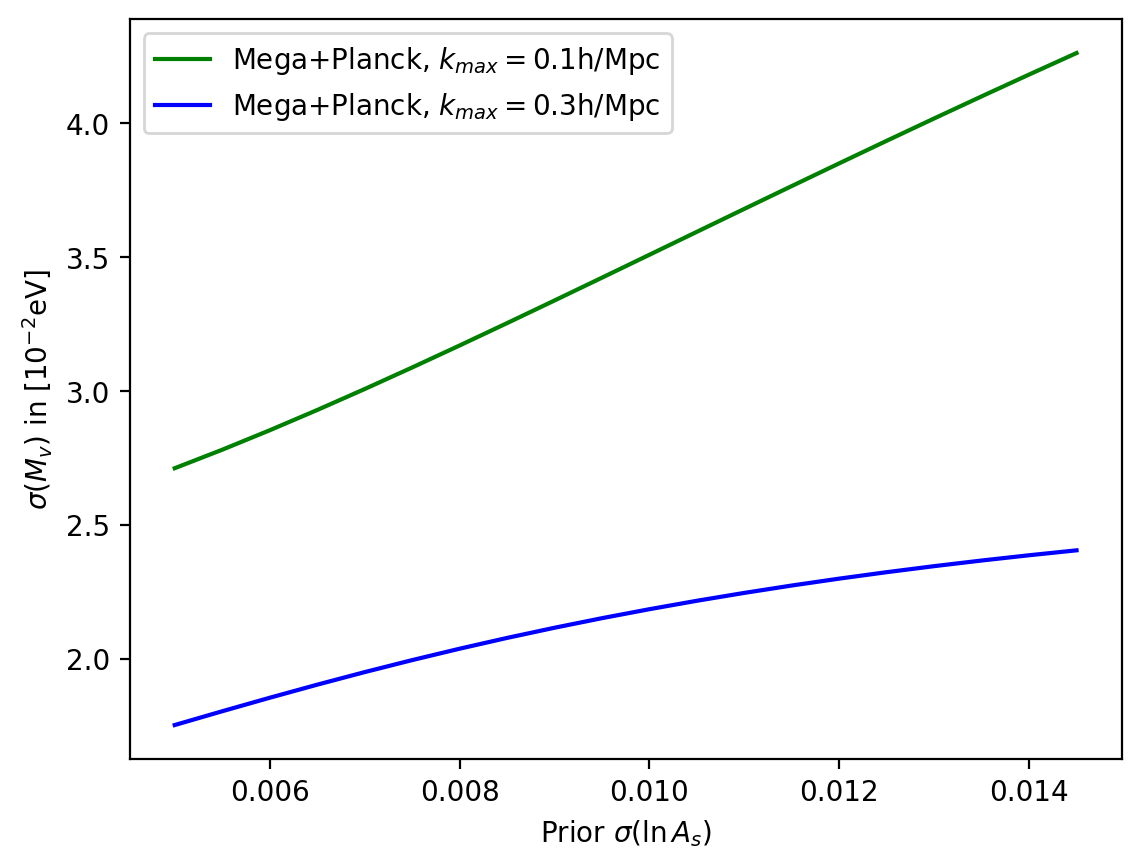

In [32]:

#%%
fig = plt.figure(dpi=200)
nAs=20
Asl=[0.005+i/nAs*0.01 for i in range(nAs)]
def Prior_Planck_As(i):
    sigma_nu=0.35#0.35
    sigma_h=0.5
    sigma_wb=0.00015
    sigma_wc= 0.00099
    sigma_ns= 0.0039
    sigma_lnAs=Asl[i]
    sigma_tau=0.0072
    return np.array([[1/sigma_nu**2,0,0,0,0,0,0],[0,1/sigma_h**2,0,0,0,0,0],[0,0,1/sigma_wb**2,0,0,0,0],[0,0,0,1/sigma_wc**2,0,0,0],[0,0,0,0,1/sigma_ns,0,0],[0,0,0,0,0,1/sigma_lnAs**2,0],[0,0,0,0,0,0,1/sigma_tau**2]])    
    #return np.array([[1/sigma_nu**2,0,0,0,0,0],[0,1/sigma_h**2,0,0,0,0],[0,0,1/sigma_wb**2,0,0,0],[0,0,0,1/sigma_wc**2,0,0],[0,0,0,1/sigma_ns,0,0],[0,0,0,0,0,1/sigma_lnAs**2]])    


Lp1=[]
Lpd1=[]
for i in range(nAs):
    kmax=0.1
    FPlanck_as=Prior_Planck_As(i)
    Fm=F_Neutrino(2,2.1,0.5,0.00079,14000,'LBG24.5',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036,14000,'LBG24.5',kmax)+F_Neutrino(3,3.1,1,0.00011,14000,'LBG24.5',kmax)+F_Neutrino(4,4.1,1,0.00007,14000,'LBG24.5',kmax)
    Lp1.append(np.linalg.inv(FPlanck_as+Fm)[0][0]**0.5*100)
    Lpd1.append(np.linalg.inv(FPlanck_as+Fm+FDesi+FDesi_Q)[0][0]**0.5*100)


Lp3=[]
Lpd3=[]

for i in range(nAs):
    kmax=0.3
    FPlanck_as=Prior_Planck_As(i)
    Fm=F_Neutrino(2,2.1,0.5,0.00079,14000,'LBG24.5',kmax)+F_Neutrino(2.5,2.6,0.5,0.00036,14000,'LBG24.5',kmax)+F_Neutrino(3,3.1,1,0.00011,14000,'LBG24.5',kmax)+F_Neutrino(4,4.1,1,0.00007,14000,'LBG24.5',kmax)
    Lp3.append(np.linalg.inv(FPlanck_as+Fm)[0][0]**0.5*100)
    Lpd3.append(np.linalg.inv(FPlanck_as+Fm+FDesi3+FDesi_Q3)[0][0]**0.5*100)
#plt.yscale('log')
#plt.yticks([0.013,0.017,0.025,0.03,0.04])
plt.plot(Asl,Lp1,c='green',label='Mega+Planck, $k_{max}=0.1$h/Mpc')
#plt.plot(Asl,Lpd1,c='green',linestyle='--',label='Mega+Planck+Desi, $k_{max}=0.1$h/Mpc')
plt.plot(Asl,Lp3,c='blue',label='Mega+Planck, $k_{max}=0.3$h/Mpc')
#plt.plot(Asl,Lpd3,c='blue',linestyle='--',label='Mega+Planck+Desi, $k_{max}=0.1$h/Mpc')

plt.xlabel('Prior $\sigma(\ln A_s)$')
plt.ylabel('$\sigma(M_{v})$ in [$10^{-2}$eV]')
plt.legend()